In [10]:
#import all the libraries
%reload_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import tensorflow as tf
from tensorflow.keras import Sequential,Model,models
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import scipy
import sklearn

In [11]:
#attain local reproducibility by setting random seed =42
RSEED = 42
import os
os.environ['PYTHONHASHSEED']=str(RSEED)
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
import random
random.seed(RSEED)
from numpy.random import seed
seed(RSEED)
from tensorflow import random as tfrand
tfrand.set_seed(RSEED)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
len(os.listdir('/content/drive/MyDrive/dataset/age_Images'))

1050

In [5]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(f'Found {gpu} - allowing memory growth')
    tf.config.experimental.set_memory_growth(gpu, True)
cpus = tf.config.list_physical_devices('CPU')
for cpu in cpus:
    print(f'Found {cpu}')

Found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') - allowing memory growth
Found PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
folder_path = "/content/drive/MyDrive/dataset/age_Images"
img_width=224
img_height=224



In [16]:
images = []
labels =[]
image_list = os.listdir(folder_path)

for i in range(len(image_list)):
    img = os.path.join(folder_path, image_list[i])
    img = image.load_img(img, target_size=(img_width,img_height))
    img = image.img_to_array(img)
    img = img/255.0
    images.append(img)
    labels.append(image_list[i].split("_",1)[0])

images=np.array(images,dtype=np.float)
labels=np.array(labels,dtype=np.int)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(images,labels, test_size=0.20, random_state=42)

In [19]:
# constructing the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [20]:
#load the vgg16 network, ensuring the head FC layer sets are left off
baseModel= tf.keras.applications.VGG16(
    input_shape=(img_width,img_height,3), include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [28]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="linear")(headModel)

In [29]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [30]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# x = VGG16.output
# # let's add a fully-connected layer
# x = Flatten()(x)
# x = Dense(32, activation='relu')(x)
# predictions = Dense(1, activation='linear')(x)

# # this is the model we will train
# model = Model(inputs=VGG16.input, outputs=predictions)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
# compile our model
print("[INFO] compiling model...")
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="mse", optimizer=opt,
	metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])

# model.compile(
#     optimizer='adam',
#     loss='mse',
#     metrics=[tf.keras.metrics.RootMeanSquaredError()])

[INFO] compiling model...


In [32]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_valid, y_valid),
	validation_steps=len(X_valid) // BS,
	epochs=EPOCHS)

# history=model.fit(X_train,y_train,batch_size=128,validation_data=(X_valid,y_valid),epochs=50)

[INFO] training head...
Epoch 1/50
26/26 [==============================] - 11s 379ms/step - loss: 926.8221 - root_mean_squared_error: 30.4402 - mean_absolute_error: 28.0686 - val_loss: 797.7032 - val_root_mean_squared_error: 28.2436 - val_mean_absolute_error: 25.7767
Epoch 2/50
26/26 [==============================] - 10s 369ms/step - loss: 737.0615 - root_mean_squared_error: 27.1399 - mean_absolute_error: 24.3351 - val_loss: 560.6500 - val_root_mean_squared_error: 23.6780 - val_mean_absolute_error: 20.6313
Epoch 3/50
26/26 [==============================] - 10s 373ms/step - loss: 524.8367 - root_mean_squared_error: 22.8999 - mean_absolute_error: 19.6367 - val_loss: 340.8318 - val_root_mean_squared_error: 18.4616 - val_mean_absolute_error: 15.2610
Epoch 4/50
26/26 [==============================] - 10s 382ms/step - loss: 346.7669 - root_mean_squared_error: 18.6041 - mean_absolute_error: 15.1050 - val_loss: 206.9599 - val_root_mean_squared_error: 14.3861 - val_mean_absolute_error: 11.8

## Evaluation

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on validation data")
results = model.evaluate(X_valid, y_valid, batch_size=32)
print("test loss, test accuracy_rmse, test accuracy_mae:", results)


Evaluate on validation data
7/7 [==============================] - 2s 265ms/step - loss: 123.9652 - root_mean_squared_error: 11.1340 - mean_absolute_error: 9.3790
test loss, test accuracy_rmse, test accuracy_mae: [123.9651870727539, 11.133965492248535, 9.378997802734375]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
y_pred = model.predict(X_valid)
print("predictions shape:", y_pred.shape)

Generate predictions
predictions shape: (210, 1)


In [ ]:
 from sklearn.metrics import explained_variance_score
 explained_variance_score(y_valid, y_pred, multioutput='raw_values')

array([0.07331223])

In [ ]:
from sklearn.metrics import max_error
max_error(y_valid, y_pred)

23.184919357299805

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_valid, y_pred)

123.96518518308672

In [ ]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_valid, y_pred)

0.16149683733162873

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_valid, y_pred)

0.06027251111746901

In [ ]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_valid, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 11.134


In [ ]:
model.save('/home/hemlata/AML_maskdetection/vgg16_agenet.h5')

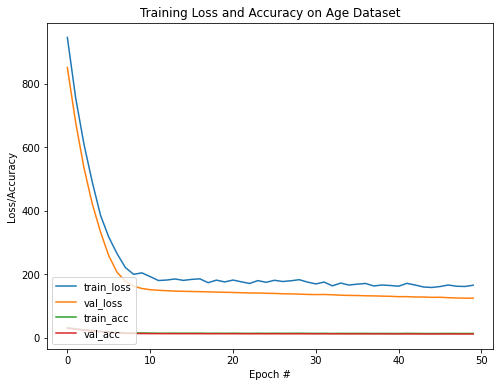

In [ ]:
N = 50
#plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["root_mean_squared_error"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_root_mean_squared_error"], label="val_acc")
plt.title("Training Loss and Accuracy on Age Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()